# **Dataset Description**

You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

This notebook will use Deep Learning methods only: LSTM, GRU

# **Extract files**

In [1]:
import os
import zipfile

zip_files = [
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip', 
    '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
]

extract_base_folder = '/kaggle/working/jigsaw-toxic-comment-classification-challenge'

os.makedirs(extract_base_folder, exist_ok=True)

for zip_file in zip_files:
    extract_folder = os.path.join(extract_base_folder, os.path.splitext(os.path.basename(zip_file))[0])
    
    if not os.path.exists(extract_folder):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
        print(f"Extracted {zip_file} to {extract_folder}")
    else:
        print(f"Skipping {zip_file}, {extract_folder} already exists.")

Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/test.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/test_labels.csv
Extracted /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip to /kaggle/working/jigsaw-toxic-comment-classification-challenge/train.csv


# **Import dependencies**

In [2]:
import os
from glob import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from gensim.models import Word2Vec

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

2025-11-29 16:47:46.468917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764434866.641801      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764434866.693454      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_df = pd.read_csv("/kaggle/working/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


- Check for null values

In [6]:
train_df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

# **Kiểm tra các comment chưa được gán nhãn**

In [7]:
x = train_df.iloc[:, 2:].sum() # Chỉ lấy các cột label
x

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [8]:
rowsums = train_df.iloc[:, 2:].sum(axis=1) # Lấy các cột label và tính tổng theo từng cột
rowsums

0         0
1         0
2         0
3         0
4         0
         ..
159566    0
159567    0
159568    0
159569    0
159570    0
Length: 159571, dtype: int64

In [9]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1
        
print('Tổng số lượng comments: ', len(train_df))
print('Số lượng comment chưa được gán nhãn: ', no_label_count)
print('Số lượng label ', x.sum())

Tổng số lượng comments:  159571
Số lượng comment chưa được gán nhãn:  143346
Số lượng label  35098


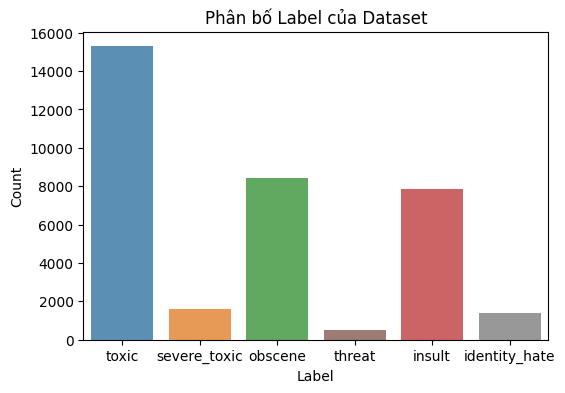

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Label của Dataset')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

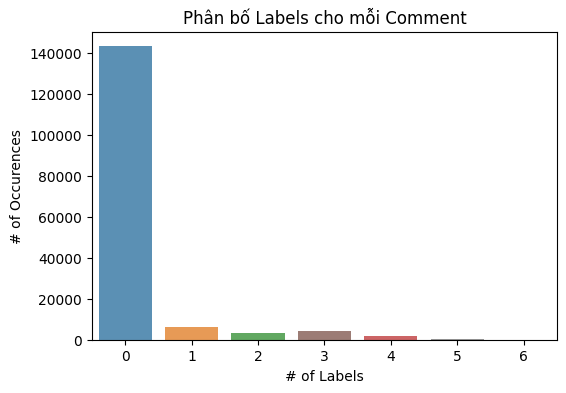

In [11]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=rowsums.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Phân bố Labels cho mỗi Comment')
plt.ylabel('# of Occurences')
plt.xlabel('# of Labels')

plt.show()

# **Data Preprocessing**

In [12]:
train_df = train_df.drop(columns=['id'], axis=1) # Drop cột id

In [13]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## **Fill các giá trị NaN (nếu có)**

In [14]:
# Fill NaN
train_df['comment_text'] = train_df['comment_text'].fillna('').astype(str)

## **Loại bỏ Stopwords**

In [15]:
# Set STOPWORDS
STOPWORDS = set(stopwords.words('english'))

In [16]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(no_stopword_text)

# **Clean text**

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip(' ')
    return text

# **Stemming**

In [18]:
stemmer = SnowballStemmer('english')

def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "
    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [19]:
train_df['comment_text'] = train_df['comment_text'].apply(remove_stopwords)
train_df['comment_text'] = train_df['comment_text'].apply(clean_text)
train_df['comment_text'] = train_df['comment_text'].apply(stemming)

In [20]:
train_df.head(15)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,d aww he match background colour i am seem stu...,0,0,0,0,0,0
2,hey man i am realli tri edit war it guy consta...,0,0,0,0,0,0
3,more i can not make real suggest improv i wond...,0,0,0,0,0,0
4,you sir hero ani chanc rememb page that on,0,0,0,0,0,0
5,congratul well use tool well talk,0,0,0,0,0,0
6,cocksuck befor you piss around on my work,1,1,1,0,1,0
7,your vandal matt shirvington articl revert ple...,0,0,0,0,0,0
8,sorri word nonsens offens you anyway i am inte...,0,0,0,0,0,0
9,align subject contrari dulithgow,0,0,0,0,0,0


In [21]:
# Các cột label gốc cho multi-label classification
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Binary target: comment được coi là toxic nếu có ÍT NHẤT một trong các label trên = 1
train_df["any_toxic"] = (train_df[label_cols].max(axis=1) > 0).astype(int)

# **Defining X, y, and Hyperparameters**

In [22]:
X_text = train_df["comment_text"].values

In [23]:
y_multi = train_df[label_cols].values
y_bin = train_df["any_toxic"].values

In [24]:
# Hyperparameters for Word2Vec + Embedding + sequences
MAX_NUM_WORDS = 100_000
MAX_LEN = 200
EMBEDDING_DIM = 300

## **Word2Vec**

In [25]:
# Train Word2Vec trên cleaned comments để học word embeddings
sentences = [text.split() for text in X_text]

w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=3,
    workers=4
)

print("Word2Vec vocab size:", len(w2v_model.wv))

Word2Vec vocab size: 47328


## **Tokenizer -> Sequences -> Padding -> Embedding Matrix**

In [26]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)

In [27]:
X_seq = tokenizer.texts_to_sequences(X_text)
X_seq = pad_sequences(X_seq, maxlen=MAX_LEN)

print("X_seq shape:", X_seq.shape)

X_seq shape: (159571, 200)


In [28]:
# Embedding Matrix cho Word2Vec
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print("Embedding matrix shape:", embedding_matrix.shape)

Embedding matrix shape: (100000, 300)


# **Split data**

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# Split indices để binary classification và multi-class classification dùng cùng split
indices = np.arange(len(X_seq))

train_idx, temp_idx = train_test_split(
    indices, test_size=0.2, random_state=42, shuffle=True
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.2, random_state=42, shuffle=True
)

In [31]:
# Multi-label splits
X_train_multi = X_seq[train_idx]
X_val_multi   = X_seq[val_idx]
X_test_multi  = X_seq[test_idx]

y_train_multi = y_multi[train_idx]
y_val_multi   = y_multi[val_idx]
y_test_multi  = y_multi[test_idx]

# Binary splits
X_train_bin = X_seq[train_idx]
X_val_bin   = X_seq[val_idx]
X_test_bin  = X_seq[test_idx]

y_train_bin = y_bin[train_idx]
y_val_bin   = y_bin[val_idx]
y_test_bin  = y_bin[test_idx]

In [32]:
print("Multi-label train/val/test shapes:", X_train_multi.shape, X_val_multi.shape, X_test_multi.shape)
print("Binary train/val/test shapes:", X_train_bin.shape, X_val_bin.shape, X_test_bin.shape)

Multi-label train/val/test shapes: (127656, 200) (25532, 200) (6383, 200)
Binary train/val/test shapes: (127656, 200) (25532, 200) (6383, 200)


# **Multi-label Classification Model (Bidirectional LSTM)**

In [33]:
num_labels = len(label_cols)
num_labels

6

In [34]:
lstm_model = Sequential()
lstm_model.add(Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=True
))

I0000 00:00:1764435031.831558      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [35]:
lstm_model.add(Bidirectional(LSTM(128, activation='tanh', return_sequences=False)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(256, activation='relu'))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(num_labels, activation='sigmoid'))

In [36]:
lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
lstm_model.build(input_shape=(None, MAX_LEN))

In [38]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 300)       │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,538,886 (116.50 MB)

 Trainable params: 30,538,886 (116.50 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history_lstm = lstm_model.fit(
    X_train_multi,
    y_train_multi,
    batch_size=256,
    epochs=8,
    validation_data=(X_val_multi, y_val_multi),
    verbose=1
)

# Prediction on validation set
y_val_proba_multi = lstm_model.predict(X_val_multi)
y_val_pred_multi  = (y_val_proba_multi > 0.5).astype(int)

Epoch 1/8


I0000 00:00:1764435037.078305     134 cuda_dnn.cc:529] Loaded cuDNN version 90300


499/499 ━━━━━━━━━━━━━━━━━━━━ 45s 81ms/step - accuracy: 0.8794 - loss: 0.1050 - val_accuracy: 0.9938 - val_loss: 0.0481
Epoch 2/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9896 - loss: 0.0443 - val_accuracy: 0.9937 - val_loss: 0.0454
Epoch 3/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9900 - loss: 0.0376 - val_accuracy: 0.9935 - val_loss: 0.0472
Epoch 4/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9781 - loss: 0.0314 - val_accuracy: 0.8895 - val_loss: 0.0475
Epoch 5/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.9857 - loss: 0.0266 - val_accuracy: 0.9913 - val_loss: 0.0523
Epoch 6/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9665 - loss: 0.0221 - val_accuracy: 0.9915 - val_loss: 0.0569
Epoch 7/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 81ms/step - accuracy: 0.6871 - loss: 0.0193 - val_accuracy: 0.9769 - val_loss: 0.0601
Epoch 8/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.6985 - loss: 0.0159 - val_accuracy: 0.95

In [40]:
def plot_training_curves(history, title_prefix=""):
    """
    Plot train/val loss and accuracy from a Keras History object.
    """
    hist = history.history
    # Check keys (just in case)
    print("History keys:", hist.keys())

    # Loss
    plt.figure(figsize=(8, 4))
    plt.plot(hist["loss"], label="Train loss")
    plt.plot(hist["val_loss"], label="Val loss")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy (or other metric name)
    acc_key = "accuracy" if "accuracy" in hist else list(hist.keys())[1]
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else list(hist.keys())[3]

    plt.figure(figsize=(8, 4))
    plt.plot(hist[acc_key], label=f"Train {acc_key}")
    plt.plot(hist[val_acc_key], label=f"Val {val_acc_key}")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

In [41]:
print("Classification report (multi-label, per class)")
print(classification_report(
    y_val_multi,
    y_val_pred_multi,
    target_names=label_cols,
    zero_division=0  # avoid warnings when a class not predicted at all
))

micro_f1 = f1_score(y_val_multi, y_val_pred_multi, average="micro", zero_division=0)
macro_f1 = f1_score(y_val_multi, y_val_pred_multi, average="macro", zero_division=0)
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

Classification report (multi-label, per class)
               precision    recall  f1-score   support

        toxic       0.77      0.78      0.77      2417
 severe_toxic       0.43      0.51      0.46       256
      obscene       0.82      0.79      0.81      1348
       threat       0.37      0.43      0.40        60
       insult       0.71      0.72      0.71      1277
identity_hate       0.47      0.56      0.51       243

    micro avg       0.73      0.74      0.73      5601
    macro avg       0.59      0.63      0.61      5601
 weighted avg       0.73      0.74      0.74      5601
  samples avg       0.07      0.07      0.06      5601

Micro F1: 0.7350
Macro F1: 0.6117


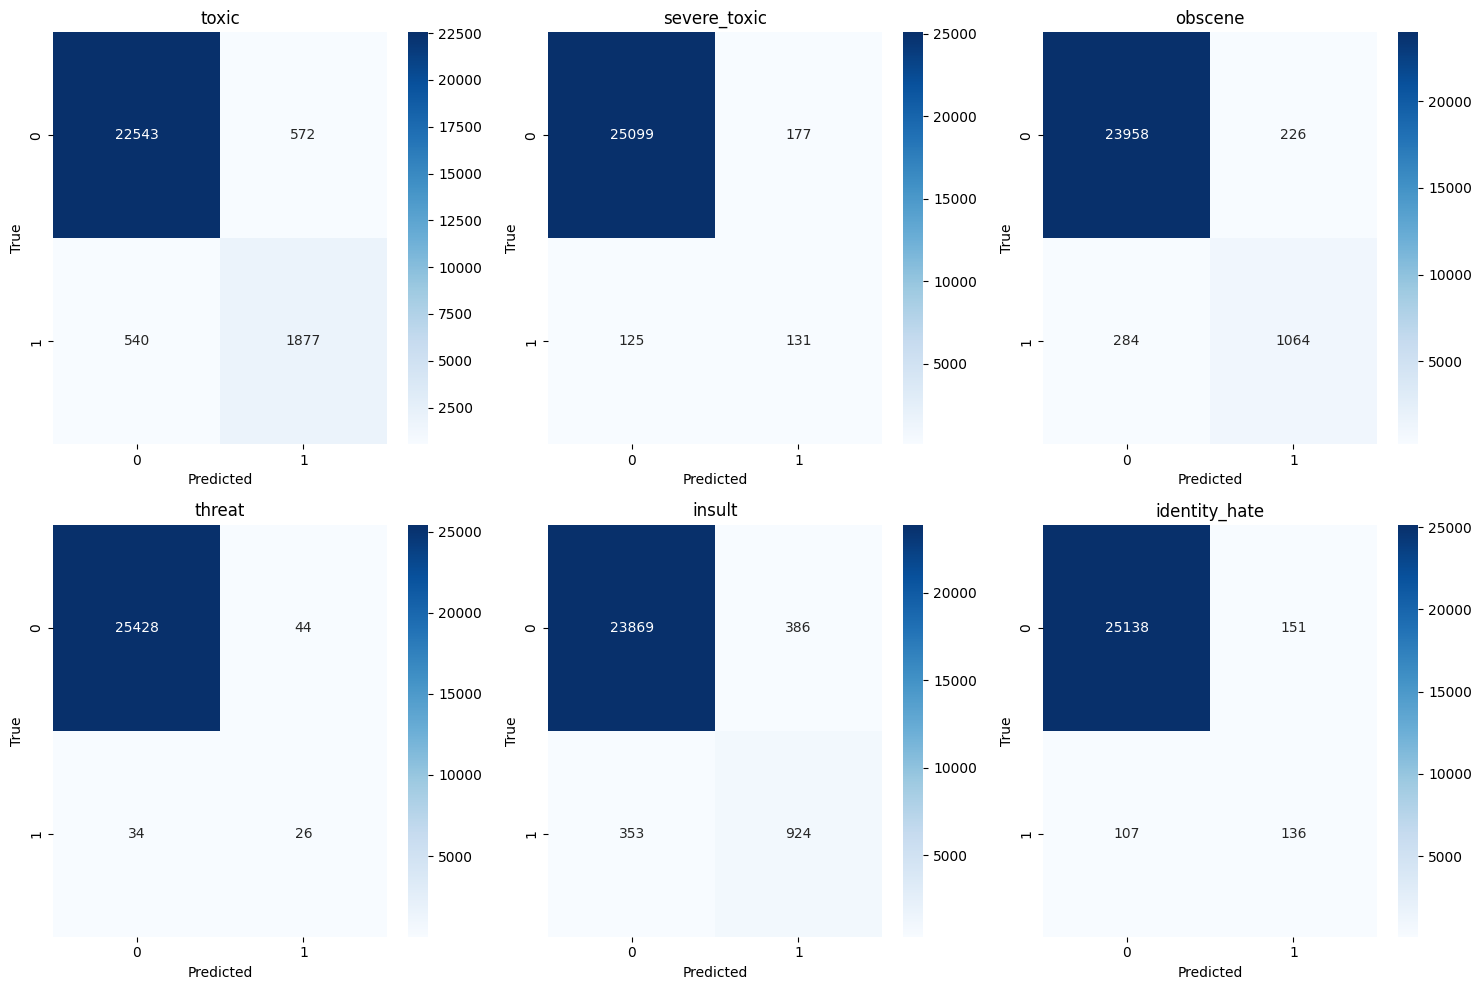

In [42]:
# Confusion matrix per label (sketch version)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, label in enumerate(label_cols):
    cm = confusion_matrix(y_val_multi[:, idx], y_val_pred_multi[:, idx])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(label)
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("True")

plt.tight_layout()
plt.show()

History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


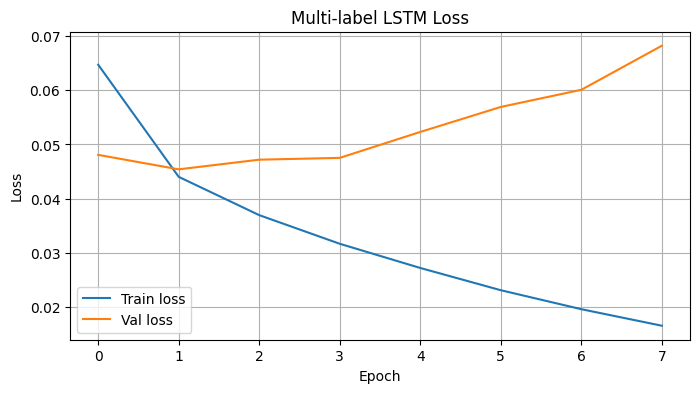

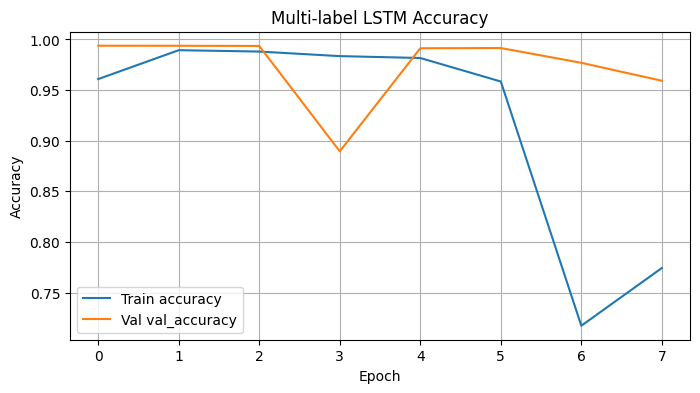

In [43]:
plot_training_curves(history_lstm, title_prefix="Multi-label LSTM")

## **Save LSTM Model**

In [44]:
import pickle
# Save the Keras model (.h5)
lstm_model.save("lstm_multilabel_word2vec.h5")
print("Saved multi-label LSTM model to lstm_multilabel_word2vec.h5")

# Save tokenizer + metadata (.pkl)
multi_artifacts = {
    "tokenizer": tokenizer,
    "label_cols": label_cols,
    "MAX_LEN": MAX_LEN,
    "MAX_NUM_WORDS": MAX_NUM_WORDS,
    "EMBEDDING_DIM": EMBEDDING_DIM,
    "threshold": 0.5,
}

with open("lstm_multilabel_artifacts.pkl", "wb") as f:
    pickle.dump(multi_artifacts, f)

print("Saved multi-label artifacts to lstm_multilabel_artifacts.pkl")

Saved multi-label LSTM model to lstm_multilabel_word2vec.h5
Saved multi-label artifacts to lstm_multilabel_artifacts.pkl


# **Binary Classification Model (GRU Model)**

In [45]:
gru_model = Sequential()
gru_model.add(Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_LEN,
    trainable=True
))

In [46]:
gru_model.add(Bidirectional(GRU(128, activation='tanh', return_sequences=False)))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(128, activation='relu'))
gru_model.add(Dense(256, activation='relu'))
gru_model.add(Dense(128, activation='relu'))
gru_model.add(Dense(1, activation='sigmoid'))

In [47]:
gru_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [48]:
gru_model.build(input_shape=(None, MAX_LEN))

In [49]:
gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 300)       │    30,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       330,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,429,185 (116.08 MB)

 Trainable params: 30,429,185 (116.08 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history_gru = gru_model.fit(
    X_train_bin,
    y_train_bin,
    batch_size=256,
    epochs=8,
    validation_data=(X_val_bin, y_val_bin),
    verbose=1
)

y_val_proba_bin = gru_model.predict(X_val_bin).ravel()
y_val_pred_bin  = (y_val_proba_bin > 0.5).astype(int)

Epoch 1/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9447 - loss: 0.1464 - val_accuracy: 0.9658 - val_loss: 0.0936
Epoch 2/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9691 - loss: 0.0816 - val_accuracy: 0.9651 - val_loss: 0.0966
Epoch 3/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9795 - loss: 0.0535 - val_accuracy: 0.9631 - val_loss: 0.1100
Epoch 4/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9873 - loss: 0.0337 - val_accuracy: 0.9613 - val_loss: 0.1372
Epoch 5/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9927 - loss: 0.0211 - val_accuracy: 0.9564 - val_loss: 0.1726
Epoch 6/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9950 - loss: 0.0136 - val_accuracy: 0.9581 - val_loss: 0.2057
Epoch 7/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - accuracy: 0.9968 - loss: 0.0094 - val_accuracy: 0.9557 - val_loss: 0.1959
Epoch 8/8
499/499 ━━━━━━━━━━━━━━━━━━━━ 38s 76ms/step - accuracy: 0.9969 - loss: 0.0086 - val_accu

Confusion matrix (binary):
[[22438   518]
 [  604  1972]]


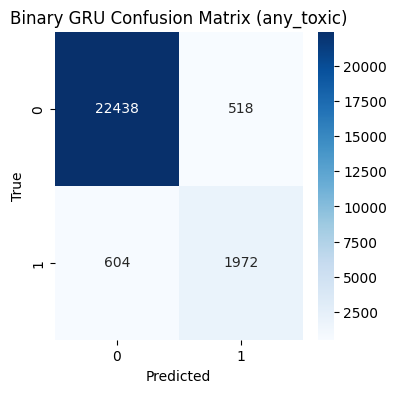

Precision: 0.7920
Recall   : 0.7655
F1-score : 0.7785

Classification report (binary)
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     22956
           1       0.79      0.77      0.78      2576

    accuracy                           0.96     25532
   macro avg       0.88      0.87      0.88     25532
weighted avg       0.96      0.96      0.96     25532



In [52]:
# Confusion matrix
cm_bin = confusion_matrix(y_val_bin, y_val_pred_bin)
print("Confusion matrix (binary):")
print(cm_bin)

plt.figure(figsize=(4, 4))
sns.heatmap(cm_bin, annot=True, fmt="d", cmap="Blues")
plt.title("Binary GRU Confusion Matrix (any_toxic)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Precision, recall, F1
precision = precision_score(y_val_bin, y_val_pred_bin, zero_division=0)
recall = recall_score(y_val_bin, y_val_pred_bin, zero_division=0)
f1 = f1_score(y_val_bin, y_val_pred_bin, zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification report (binary)")
print(classification_report(y_val_bin, y_val_pred_bin, zero_division=0))

History keys: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


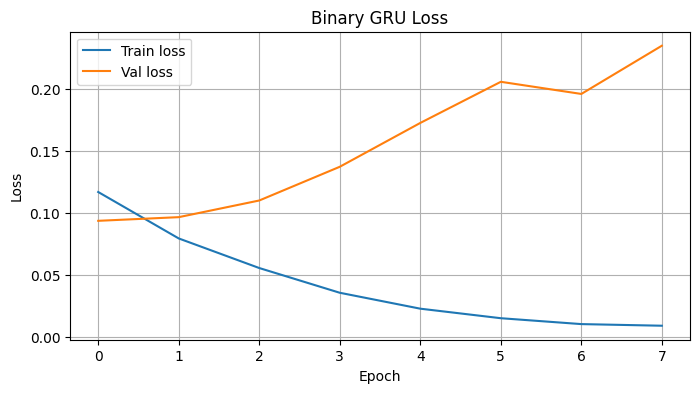

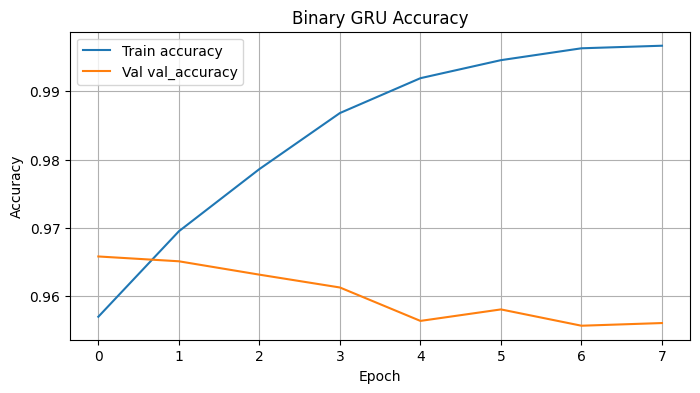

In [54]:
plot_training_curves(history_gru, title_prefix="Binary GRU")

## **Save model**

In [55]:
binary_artifacts = {
    "tokenizer": tokenizer,       
    "label_name": "any_toxic",
    "MAX_LEN": MAX_LEN,
    "MAX_NUM_WORDS": MAX_NUM_WORDS,
    "EMBEDDING_DIM": EMBEDDING_DIM,
    "threshold": 0.5,             
}

with open("gru_binary_artifacts.pkl", "wb") as f:
    pickle.dump(binary_artifacts, f)

print("Saved binary artifacts to gru_binary_artifacts.pkl")

gru_model.save("gru_binary_word2vec.h5")
print("Saved binary model to gru_binary_word2vec.h5")

Saved binary artifacts to gru_binary_artifacts.pkl
Saved binary model to gru_binary_word2vec.h5


# **Test Prediction**

In [56]:
test_path = "/kaggle/working/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv"

In [57]:
test_df = pd.read_csv(test_path)
test_df.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [58]:
# Xử lý NaN
test_df["comment_text"] = test_df["comment_text"].fillna("").astype(str)

# xóa stopwords -> làm sạch text -> stemming
test_df["comment_text"] = test_df["comment_text"].apply(remove_stopwords)
test_df["comment_text"] = test_df["comment_text"].apply(clean_text)
test_df["comment_text"] = test_df["comment_text"].apply(stemming)

test_df.head(10)

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succes ever what hate sad mof...
1,0000247867823ef7,from rfc the titl fine is imo
2,00013b17ad220c46,sourc zaw ashton lapland
3,00017563c3f7919a,if look back sourc inform i updat correct form...
4,00017695ad8997eb,i anonym edit articl all
5,0001ea8717f6de06,thank understand i think high would revert wit...
6,00024115d4cbde0f,pleas add nonsens wikipedia such edit consid v...
7,000247e83dcc1211,dear god site horribl
8,00025358d4737918,onli fool believ number the correct number lie...
9,00026d1092fe71cc,doubl redirect when fix doubl redirect blank o...


In [60]:
test_seqs = tokenizer.texts_to_sequences(test_df["comment_text"].tolist())
test_seqs = pad_sequences(test_seqs, maxlen=MAX_LEN)

print("Test sequences shape:", test_seqs.shape)

Test sequences shape: (153164, 200)


In [61]:
test_probs = lstm_model.predict(test_seqs, batch_size=256)

599/599 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step


In [62]:
submission = pd.DataFrame(test_probs, columns=label_cols)
submission.insert(0, "id", test_df["id"])
submission = submission[["id"] + label_cols]

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
submission.head()

Saved submission.csv


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,9.827859e-01,2.101035e-01,9.824985e-01,1.231235e-02,9.339150e-01,2.164537e-01
1,0000247867823ef7,3.844983e-07,1.285184e-12,4.379861e-10,2.409186e-09,7.760695e-08,8.488963e-08
2,00013b17ad220c46,5.886328e-05,8.535329e-09,3.982437e-07,1.291154e-06,1.906359e-05,1.340309e-05
3,00017563c3f7919a,2.056227e-06,1.770876e-11,1.820044e-09,1.076496e-07,1.229596e-07,2.037540e-07
4,00017695ad8997eb,1.384682e-05,2.165217e-10,6.605108e-09,3.406898e-07,8.038858e-07,1.353736e-06
